In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
from scipy.stats import t 
from itertools import product
import pystan

from viabel.approximations import MFStudentT
from viabel.models import make_stan_log_density
from viabel.optimization import adagrad_optimize
from experiments import *

sns.set_style('white')
sns.set_context('notebook', font_scale=2.5, rc={'lines.linewidth': 2})

# Eight Schools Model

For more details on this example, see:

[Practical posterior error bounds from variational objectives](https://arxiv.org/abs/1910.04102).
Jonathan H. Huggins,
Miko&#0322;aj Kasprzak,
Trevor Campbell,
Tamara Broderick.
In *Proc. of the 23rd International Conference on Artificial Intelligence and
Statistics* (AISTATS), Palermo, Italy. PMLR: Volume 108, 2020.

In [2]:
os.makedirs('../figures', exist_ok=True)

logtau_lim = [-2, 3.5]
mu_lim = [-5, 15]
theta1_lim = [-8, 22]

skip = 1 # how much to thin samples; larger values make the plots faster but let accurate 

In [3]:
def plot_sample_contours(x_samples1, y_samples1, x_samples2, y_samples2, xlabel, ylabel, xlim, ylim, 
                    cmap1, cmap2, savepath=None, **kwargs):
    sns.kdeplot(x_samples1, y_samples1, cmap=cmap1, **kwargs)
    sns.kdeplot(x_samples2, y_samples2, cmap=cmap2, **kwargs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks([])
    plt.yticks([])
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
def plot_sample_and_density_contours(x_samples, y_samples, logdensity, xlabel, ylabel, xlim, ylim, 
                    cmap_samples, cmap_density, savepath=None, **kwargs):
    sns.kdeplot(x_samples, y_samples, cmap=cmap_samples, **kwargs)
    x = np.linspace(*xlim, 100)
    y = np.linspace(*ylim, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.concatenate([X[:,:,np.newaxis], Y[:,:,np.newaxis]], axis=2)
    Z = np.exp(logdensity(XY))
    plt.contour(X, Y, Z, cmap=cmap_density, linestyles='solid')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks([])
    plt.yticks([])
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
def tranform_to_theta(ncp_samples):
    ncp_samples_tranformed = ncp_samples.copy()
    ncp_samples_tranformed[2:] = (ncp_samples_tranformed[0] 
                                  + np.exp(ncp_samples_tranformed[1]) * ncp_samples_tranformed[2:])
    return ncp_samples_tranformed

def get_ncp_approx_samples(var_family, opt_param, n_samples):
    ncp_samples = var_family.sample(opt_param, n_samples).T
    return ncp_samples, tranform_to_theta(ncp_samples)

## Model compilation and ground truth sampling

Compile Stan models

In [4]:
eight_schools_cp_stan_model = pystan.StanModel(file='eight_schools_cp.stan' ,
                                               model_name='eight_schools_cp')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL eight_schools_cp_b061d14b15cea7d7e6cf0b7700a8b143 NOW.


In [5]:
eight_schools_ncp_stan_model = pystan.StanModel(file='eight_schools_ncp.stan',
                                                model_name='eight_schools_ncp')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL eight_schools_ncp_83f1609305e7267422b692fbee65a5db NOW.


Construct eight schools data and fit models. Note that fitting the centered parameterization model is problematic. 

In [6]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
data = dict(J=J, y=y, sigma=sigma)

In [7]:
eight_schools_cp_fit = eight_schools_cp_stan_model.sampling(data=data, iter=11000, warmup=1000,
                                                            control=dict(adapt_delta=.99))

In [8]:
eight_schools_ncp_fit = eight_schools_ncp_stan_model.sampling(data=data, iter=32000, warmup=2000, thin=3,
                                                              control=dict(adapt_delta=.95))

In [9]:
eight_schools_ncp_fit

Inference for Stan model: eight_schools_ncp_83f1609305e7267422b692fbee65a5db.
4 chains, each with iter=32000; warmup=2000; thin=3; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               4.37    0.02   3.32  -2.19   2.15   4.39    6.6  10.88  39487    1.0
tau              3.59    0.02   3.21   0.12   1.25   2.74   4.98   12.0  38835    1.0
theta_tilde[1]   0.31  5.0e-3   0.99  -1.66  -0.35   0.33   0.99   2.23  39732    1.0
theta_tilde[2]    0.1  4.7e-3   0.94  -1.77  -0.52    0.1   0.72   1.93  39331    1.0
theta_tilde[3]  -0.08  4.8e-3   0.97  -1.97  -0.73  -0.08   0.57   1.81  40537    1.0
theta_tilde[4]   0.06  4.7e-3   0.94  -1.79  -0.57   0.06   0.69   1.93  40215    1.0
theta_tilde[5]  -0.16  4.6e-3   0.94  -1.99  -0.78  -0.17   0.45   1.72  40622    1.0
theta_tilde[6]  -0.06  4.7e-3   0.94  -1.92   -0.7  -0.06   0.57   1.77  40229    1.0
theta_tilde[7]   0.36  4.8e

Record relevant information from both models and use samples from non-centered model as ground truth

In [10]:
# number of parameters and parameter names in centered model
n_params_cp = len(eight_schools_cp_fit.constrained_param_names())
param_names_cp = ['mu', 'log_tau'] + eight_schools_cp_fit.flatnames[2:n_params_cp]

# number of parameters and parameter names in non-centered model
n_params_ncp = len(eight_schools_ncp_fit.constrained_param_names())
param_names_ncp = ['mu', 'log_tau'] + eight_schools_ncp_fit.flatnames[2:n_params_ncp]
param_names_ncp_transformed = ['mu', 'log_tau'] + eight_schools_ncp_fit.flatnames[n_params_ncp:]

# the centered and tranformed non-centered parameters should be the same
np.testing.assert_array_equal(param_names_cp, param_names_ncp_transformed)

# construct matrix of samples (both original and transformed) from non-centered model 
samples_ncp_df = eight_schools_ncp_fit.to_dataframe(pars=eight_schools_ncp_fit.flatnames)
samples_ncp_df['log_tau'] = np.log(samples_ncp_df['tau'])
samples_ncp = samples_ncp_df.loc[:,param_names_ncp].values.T
samples_ncp_transformed = samples_ncp_df.loc[:,param_names_ncp_transformed].values.T

# use samples from non-centered model for ground true mean and covariance
true_mean_ncp = np.mean(samples_ncp, axis=1)
true_cov_ncp = np.cov(samples_ncp)
true_mean_ncp_tranformed = np.mean(samples_ncp_transformed, axis=1)
true_cov_ncp_tranformed = np.cov(samples_ncp_transformed)

## Variational inference for centered model (df = 40)

|--------------|
|     KLVI     |
|--------------|


Average Loss = 8.5905: 100%|██████████| 10000/10000 [00:41<00:00, 243.69it/s]


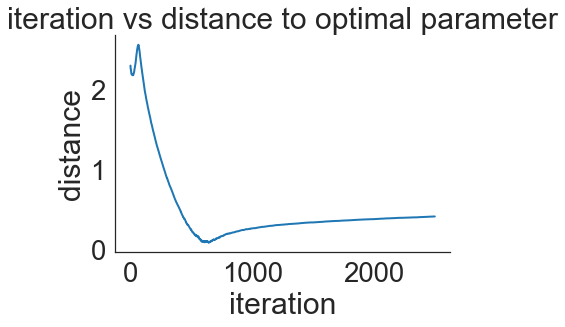

mean   = [4.2548679  1.71682622 6.72530269 5.04207232 3.60591679 4.7618783
 2.99357712 3.70935808 7.10854563 4.85361225]
stdevs = [1.77716307 0.25409754 4.97546636 4.63880337 4.99272816 4.72681988
 4.53748149 4.72928113 4.65312662 5.0444328 ]

mean error             = 1.56
stdev error            = 1.98
||cov error||_2^{1/2}  = 8.53
||true cov||_2^{1/2}   = 9.67

Computing CUBO and ELBO with 2500000 samples took 30.228 sec to run

Bounds on...
  2-Wasserstein   2.71e+03
  2-divergence    18.2
  mean error      2.71e+03
  stdev error     2.71e+03
  sqrt cov error  3.83e+03
  cov error       1.47e+07

Results with PSIS correction
----------------------------


/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.899

mean   = [4.79292228 1.54302744 7.72291838 5.7428646  4.51119672 5.70779412
 3.46693144 3.30978885 7.99558128 5.50112353]
stdevs = [3.00203376 0.4710016  6.40766598 5.23804727 5.92794126 5.44791689
 4.76405735 5.37078485 6.00049453 5.3219976 ]

mean error             = 3.01
stdev error            = 1.92
||cov error||_2^{1/2}  = 6.15
||true cov||_2^{1/2}   = 9.67

|---------------|
|     CHIVI     |
|---------------|


Average Loss = 9.2235: 100%|██████████| 10000/10000 [03:47<00:00, 43.89it/s]


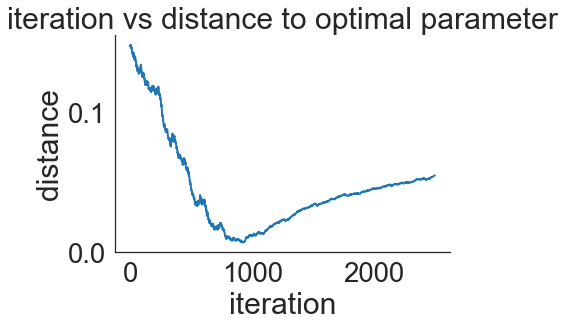

mean   = [4.37815328 0.8996789  6.17687797 4.93870469 3.92117919 4.71440939
 3.58937127 4.06811689 6.30181956 4.83350544]
stdevs = [3.14432364 1.13205464 5.6792647  4.72843119 5.35842075 4.81959586
 4.77967393 4.85332588 5.1056932  5.29464086]

mean error             = 0.102
stdev error            = 0.286
||cov error||_2^{1/2}  = 8.32
||true cov||_2^{1/2}   = 9.67

Computing CUBO and ELBO with 2500000 samples took 28.929 sec to run

Bounds on...
  2-Wasserstein   587
  2-divergence    11.7
  mean error      587
  stdev error     587
  sqrt cov error  834
  cov error       6.96e+05

Results with PSIS correction
----------------------------


/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)
/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/virtual-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


khat = 0.918

mean   = [4.20171151 1.14000664 6.38475955 4.57513018 4.11541065 4.7934173
 2.94150226 4.07311512 6.48601656 4.69371957]
stdevs = [3.21920354 0.79359717 5.57643    4.63055202 5.84743114 5.02346744
 4.43797254 4.97698691 5.50085637 5.11597844]

mean error             = 0.921
stdev error            = 0.947
||cov error||_2^{1/2}  = 4.81
||true cov||_2^{1/2}   = 9.67


In [11]:
eight_schools_cp_log_density = make_stan_log_density(eight_schools_cp_fit)
var_family_cp = MFStudentT(n_params_cp, 40)

init_param_cp = np.concatenate([true_mean_ncp_tranformed, .5*np.log(np.diag(true_cov_ncp_tranformed))])
klvi_cp, chivi_cp, klvi_cp_results, chivi_cp_results, other_klvi_cp_results, other_chivi_cp_results = \
    run_experiment(eight_schools_cp_log_density, var_family_cp, init_param_cp, 
                   true_mean_ncp_tranformed, true_cov_ncp_tranformed, 
                   learning_rate=.01, learning_rate_end=.001,
                   n_iters=10000, bound_w2=2500000, verbose=True)

/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/virtual-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


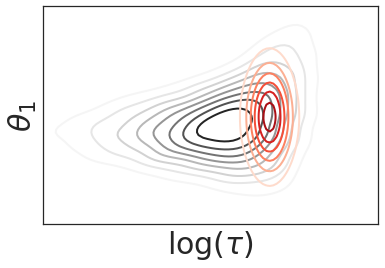

/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/virtual-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


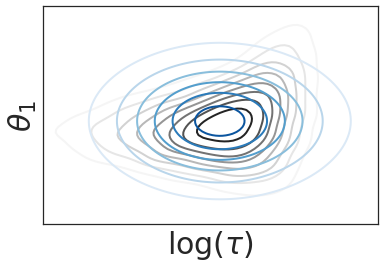

In [12]:
def cp_results_plot(other_results, method):
    if method not in ['klvi', 'chivi']:
        print('invalid method "{}"'.format(method))
        return
    cp_opt_param = other_results['opt_param']
    cp_mean, cp_log_scale = cp_opt_param[:n_params_cp], cp_opt_param[n_params_cp:]
    cp_log_density = lambda x: np.sum(t.logpdf(x, 40, cp_mean[np.newaxis,np.newaxis,1:3], 
                                               np.exp(cp_log_scale[np.newaxis,np.newaxis,1:3])), axis=-1)
    cmap2 = 'Reds' if method == 'klvi' else 'Blues'
    plot_sample_and_density_contours(
        np.log(eight_schools_ncp_fit['tau'][::skip]), eight_schools_ncp_fit['theta[1]'][::skip],
        cp_log_density, r'$\log(\tau)$', r'$\theta_1$', 
        logtau_lim, theta1_lim, 'Greys', cmap2,
        '../figures/8-schools-cp-log-tau-vs-theta1-{}.pdf'.format(method))

cp_results_plot(other_klvi_cp_results, 'klvi')
cp_results_plot(other_chivi_cp_results, 'chivi')

## Variational inference for non-centered model (df = 40)

|--------------|
|     KLVI     |
|--------------|


Average Loss = 6.8054: 100%|██████████| 5000/5000 [00:20<00:00, 244.12it/s]


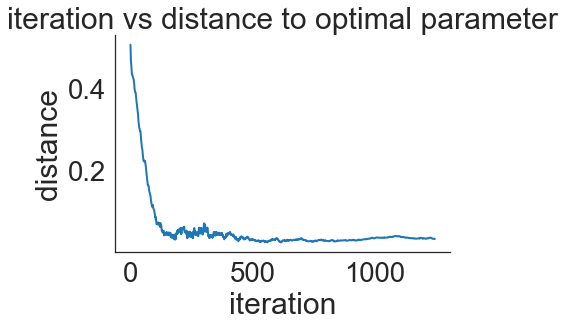

mean   = [ 4.51131249  0.78667104  0.28239049  0.08753587 -0.07943665  0.0547455
 -0.16754576 -0.0752208   0.33956798  0.06453592]
stdevs = [3.16252502 0.74079071 0.97074507 0.93418747 0.97296319 0.94295875
 0.91951002 0.94149989 0.93300904 0.97727544]

mean error             = 0.146
stdev error            = 0.458
||cov error||_2^{1/2}  = 1.25
||true cov||_2^{1/2}   = 3.33

Computing CUBO and ELBO with 2500000 samples took 24.431 sec to run

Bounds on...
  2-Wasserstein   28.3
  2-divergence    4.31
  mean error      28.3
  stdev error     28.3
  sqrt cov error  42.2
  cov error       1.78e+03

Results with PSIS correction
----------------------------


/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.641

mean   = [ 4.40131489  0.84066206  0.32231956  0.09557508 -0.08529956  0.06187849
 -0.16068916 -0.07355865  0.35248156  0.07835067]
stdevs = [3.31210203 1.07929863 0.99090488 0.93759254 0.967851   0.94293877
 0.93138389 0.94239439 0.97390818 0.97307234]

mean error             = 0.0538
stdev error            = 0.0924
||cov error||_2^{1/2}  = 0.458
||true cov||_2^{1/2}   = 3.33

|---------------|
|     CHIVI     |
|---------------|


Average Loss = 8.2397: 100%|██████████| 5000/5000 [01:36<00:00, 51.69it/s]


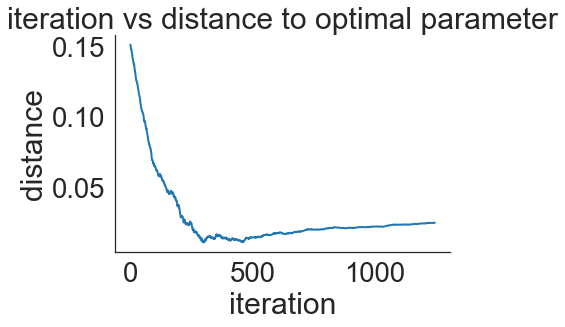

mean   = [ 4.37789458  0.91702471  0.3371867   0.10019934 -0.0980784   0.06202467
 -0.17523217 -0.07956283  0.37383845  0.0779775 ]
stdevs = [3.3693956  1.13349886 0.99832488 0.93762175 0.96998905 0.94384535
 0.9341394  0.94711062 0.97411023 0.97637447]

mean error             = 0.124
stdev error            = 0.0657
||cov error||_2^{1/2}  = 0.964
||true cov||_2^{1/2}   = 3.33

Computing CUBO and ELBO with 2500000 samples took 25.983 sec to run

Bounds on...
  2-Wasserstein   16.8
  2-divergence    2.1
  mean error      16.8
  stdev error     16.8
  sqrt cov error  26.1
  cov error       681

Results with PSIS correction
----------------------------


/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.622

mean   = [ 4.40779293  0.80151937  0.31748643  0.09773489 -0.08500615  0.06244251
 -0.16258991 -0.07316123  0.35806324  0.07527079]
stdevs = [3.32194939 1.17881433 0.98671835 0.93520911 0.96704653 0.94519922
 0.92740319 0.94200483 0.95919494 0.97370788]

mean error             = 0.0377
stdev error            = 0.0158
||cov error||_2^{1/2}  = 0.277
||true cov||_2^{1/2}   = 3.33


In [13]:
eight_schools_ncp_log_density = make_stan_log_density(eight_schools_ncp_fit)
var_family_ncp = MFStudentT(n_params_ncp, 40)

init_param_ncp = np.concatenate([true_mean_ncp, .5*np.log(np.diag(true_cov_ncp))])
klvi_ncp, chivi_ncp, klvi_ncp_results, chivi_ncp_results, other_klvi_ncp_results, other_chivi_ncp_results = \
    run_experiment(eight_schools_ncp_log_density, var_family_ncp, init_param_ncp, true_mean_ncp, true_cov_ncp, 
                   learning_rate=.01, learning_rate_end=.001,
                   n_iters=5000, bound_w2=2500000, verbose=True)

In [14]:
n_samples = eight_schools_ncp_fit['tau'][::skip].size
klvi_ncp_samples, klvi_ncp_samples_tranformed = \
    get_ncp_approx_samples(var_family_ncp, other_klvi_ncp_results['opt_param'], n_samples)
chivi_ncp_samples, chivi_ncp_samples_tranformed = \
    get_ncp_approx_samples(var_family_ncp, other_chivi_ncp_results['opt_param'], n_samples)

/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/virtual-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/virtual-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


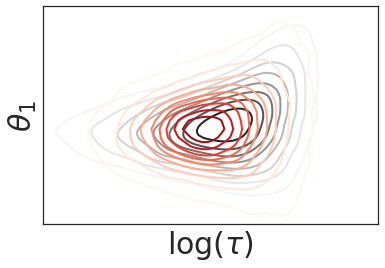

/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/virtual-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/virtual-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


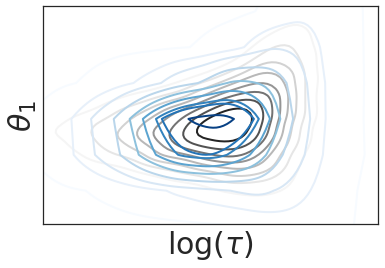

In [15]:
def plot_cp_results(ncp_samples_tranformed, method):
    if method not in ['klvi', 'chivi']:
        print('invalid method "{}"'.format(method))
        return
    cmap2 = 'Reds' if method == 'klvi' else 'Blues'
    plot_sample_contours(np.log(eight_schools_ncp_fit['tau'][::skip]), eight_schools_ncp_fit['theta[1]'][::skip], 
                         ncp_samples_tranformed[1], ncp_samples_tranformed[2], 
                         r'$\log(\tau)$', r'$\theta_1$', 
                         logtau_lim, theta1_lim, 'Greys', cmap2,
                         '../figures/8-schools-ncp-log-tau-vs-theta1-{}.pdf'.format(method))
plot_cp_results(klvi_ncp_samples_tranformed, 'klvi')
plot_cp_results(chivi_ncp_samples_tranformed, 'chivi')

## Variational inference for non-centered model (df=8)

|--------------|
|     KLVI     |
|--------------|


Average Loss = 9.0967: 100%|██████████| 5000/5000 [00:17<00:00, 277.81it/s]


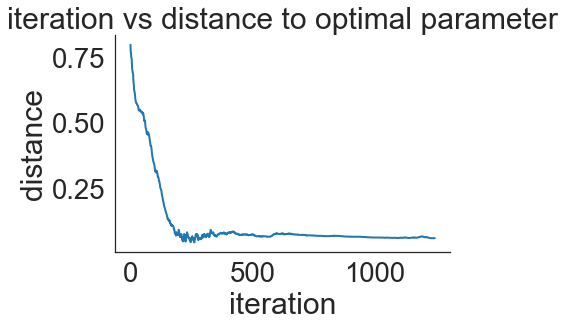

mean   = [ 4.51367558  0.79361517  0.2767544   0.08256452 -0.07644952  0.0522639
 -0.16456439 -0.07216737  0.33105398  0.06175302]
stdevs = [3.1796344  0.70082148 0.96881792 0.93229004 0.97033391 0.94022745
 0.92133673 0.94165656 0.93284831 0.97795243]

mean error             = 0.151
stdev error            = 0.491
||cov error||_2^{1/2}  = 1.23
||true cov||_2^{1/2}   = 3.33



/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/viabel/bounds.py:193: UserWarning: significant Monte Carlo error when computing ELBO (mean = 6.634981163743446, standard deviation = 0.3393032837421803)
  warn(msg)


Computing CUBO and ELBO with 2500000 samples took 22.973 sec to run

Bounds on...
  2-Wasserstein   32.6
  2-divergence    4.63
  mean error      32.6
  stdev error     32.6
  sqrt cov error  48.3
  cov error       2.33e+03

Results with PSIS correction
----------------------------


/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.524

mean   = [ 4.41169168  0.79991275  0.3102074   0.09402918 -0.08355833  0.06117157
 -0.15797738 -0.07714923  0.35701462  0.07480933]
stdevs = [3.31212656 1.17002745 0.99071692 0.93644797 0.96635897 0.94552925
 0.93092279 0.94251718 0.95826447 0.97547194]

mean error             = 0.0427
stdev error            = 0.0108
||cov error||_2^{1/2}  = 0.289
||true cov||_2^{1/2}   = 3.33

|---------------|
|     CHIVI     |
|---------------|


Average Loss = 8.2214: 100%|██████████| 5000/5000 [01:24<00:00, 59.48it/s]


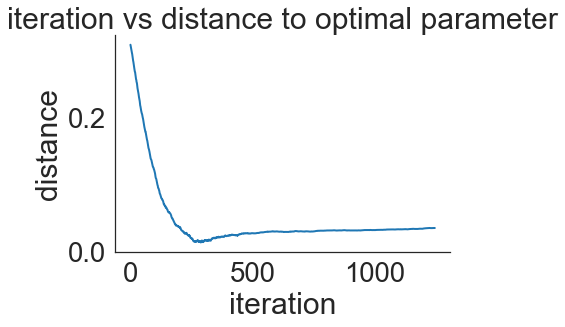

mean   = [ 4.38451365  0.96281358  0.32814868  0.09923059 -0.09335489  0.06207719
 -0.1761966  -0.07792298  0.36720771  0.07733073]
stdevs = [3.53469695 1.25507595 1.05866136 0.99089188 1.02936146 1.00211524
 0.98968125 1.00352122 1.0292565  1.03558256]

mean error             = 0.167
stdev error            = 0.289
||cov error||_2^{1/2}  = 1.35
||true cov||_2^{1/2}   = 3.33

Computing CUBO and ELBO with 2500000 samples took 25.880 sec to run

Bounds on...
  2-Wasserstein   25.4
  2-divergence    3.23
  mean error      25.4
  stdev error     25.4
  sqrt cov error  38.4
  cov error       1.48e+03

Results with PSIS correction
----------------------------


/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.427

mean   = [ 4.38942883  0.80302842  0.31603907  0.09885261 -0.08445007  0.06276106
 -0.15982345 -0.07132852  0.35775084  0.07715761]
stdevs = [3.32023969 1.1725712  0.98746749 0.93756009 0.9676598  0.94156299
 0.92962497 0.94388887 0.96132391 0.97381002]

mean error             = 0.0207
stdev error            = 0.0114
||cov error||_2^{1/2}  = 0.221
||true cov||_2^{1/2}   = 3.33


In [16]:
var_family_ncp_8 = MFStudentT(n_params_ncp, 8)
run_experiment(eight_schools_ncp_log_density, var_family_ncp_8, init_param_ncp, true_mean_ncp, true_cov_ncp, 
               learning_rate=.01, learning_rate_end=.001,
               n_iters=5000, bound_w2=2500000, verbose=True);